# REZ capacity factors

- Compare mean capacity factors computed with BARRA-C2 with those computed with ERA5 and AEMO's published data

In [34]:
# client.close()
# cluster.close()

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
PROJECT = "dt6"

In [3]:
walltime = "03:00:00"
cores = 48
memory = str(4 * cores) + "GB"

cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    processes=cores,
    job_extra_directives=[
        "-q normal",
        "-P "+PROJECT,
        "-l ncpus="+str(cores),
        "-l mem="+str(memory),
        "-l storage=gdata/xp65+gdata/w42+scratch/w42+gdata/gb02+scratch/gb02+gdata/ng72+scratch/ng72+gdata/rt52"
         # "-l storage=gdata/w42+scratch/w42+gdata/gb02+scratch/gb02+gdata/ng72+scratch/ng72+gdata/rt52"
    ],
    local_directory="$TMPDIR",
    job_directives_skip=["select"],
    log_directory="/scratch/w42/dr6273/tmp/logs"
)

In [4]:
cluster.scale(jobs=1)
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.1:45559,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
import xarray as xr
import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt

## Load data

Capacity factor

In [7]:
cf_paths = sorted(glob.glob("/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/*.zarr"))

In [8]:
cf_paths = cf_paths[32:-1]

In [9]:
datasets = [xr.open_zarr(p, chunks={}) for p in cf_paths]

In [10]:
cf = xr.combine_by_coords(datasets, compat="override", data_vars="minimal", coords="minimal")

In [11]:
cf = cf.cf100m

In [12]:
cf

<xarray.DataArray 'cf100m' (time: 341856, lat: 737, lon: 506)> Size: 510GB
dask.array<concatenate, shape=(341856, 737, 506), dtype=float32, chunksize=(72, 737, 506), chunktype=numpy.ndarray>
Coordinates:
    crs      int32 4B ...
    height   float64 8B ...
  * lat      (lat) float64 6kB -43.37 -43.33 -43.29 ... -14.01 -13.97 -13.93
  * lon      (lon) float64 4kB 133.5 133.5 133.6 133.6 ... 153.6 153.7 153.7
  * time     (time) datetime64[ns] 3MB 2011-01-01 ... 2023-12-31T23:40:00

REZ mask

In [13]:
rez_mask = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_2024_mask_BARRA-C2_grid.nc"
)["REZ"]

### Analysis

In [14]:
def compute_rez_means(cf_da, time_step="20min"):
    """
    Compute the REZ mean capacity factor

    cf_da: array, capacity factors
    time_step: str, "20min" or "Xhr", where X indicates every X-hourly time step
    """
    if time_step == "20min":
        skip = None
    elif time_step[-2:] == "hr":
        skip = int(time_step[:-2])
    else:
        raise ValueError("Incorrect time_step specified")

    # Set up empty DataFrame
    rez_means = pd.DataFrame(index=rez_mask.region.values, columns=["raw_mean"])
    
    # Select desired time steps
    cf_da = cf.sel(time=slice(None, None, skip))
    
    # Loop through REZs and compute mean
    for r in rez_means.index[:]:
        r_cf = cf_da.where(rez_mask.sel(region=r), drop=True)
        rez_means.loc[r] = r_cf.mean().values
        
    # Write the capacity factor stats to file
    rez_means.to_csv(
        "/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/capacity_factor_REZ_mean_2011-2023_"+time_step+".csv"
    )

REZ-mean for 20min data

In [15]:
compute = False

In [31]:
if compute:
    compute_rez_means(cf, "20min")
rez_means_barra_20m = pd.read_csv(
    "/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/capacity_factor_REZ_mean_2011-2023_20min.csv",
    index_col=0
)

REZ-mean for 1hr data (just select each 20-min timestep on the hour)

In [17]:
if compute:
    compute_rez_means(cf, "1hr")
rez_means_barra_1hr = pd.read_csv(
    "/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/capacity_factor_REZ_mean_2011-2023_1hr.csv",
    index_col=0
)

REZ-mean for 12hr data

In [24]:
compute = False

In [25]:
if compute:
    compute_rez_means(cf, "12hr")
rez_means_barra_12hr = pd.read_csv(
    "/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/capacity_factor_REZ_mean_2011-2023_12hr.csv",
    index_col=0
)

REZ-mean for 24hr data

In [26]:
if compute:
    compute_rez_means(cf, "24hr")
rez_means_barra_24hr = pd.read_csv(
    "/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/capacity_factor_REZ_mean_2011-2023_24hr.csv",
    index_col=0
)

REZ-mean for 1-week (504 hours) data

In [27]:
if compute:
    compute_rez_means(cf, "504hr")
rez_means_barra_1wk = pd.read_csv(
    "/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/capacity_factor_REZ_mean_2011-2023_504hr.csv",
    index_col=0
)

Load AEMO and ERA5 stats

In [28]:
# Load AEMO obs and ERA5 REZ stats
cf_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/capacity_factor/van_der_Wiel/bias_corrected/"

rez_means_era5_aemo = pd.read_csv(
    cf_path + "wind_medium_capacity_factor_van_der_Wiel_era5_REZ_statistics.csv",
    index_col=0
)

Text(0.5, 0, 'REZ')

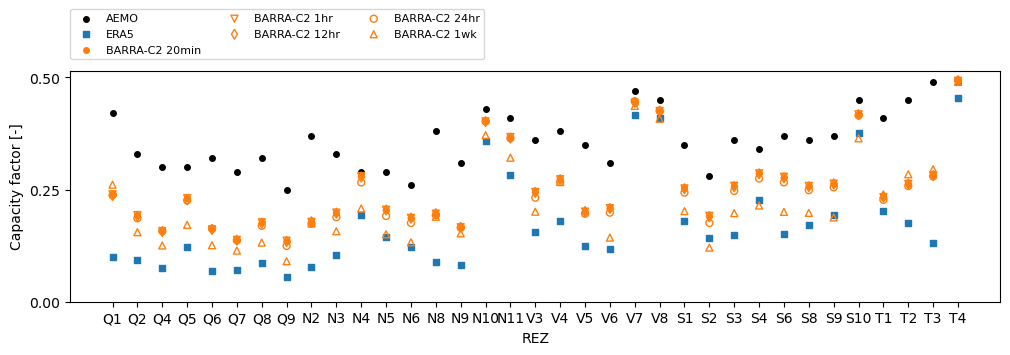

In [37]:
fig, ax = plt.subplots(figsize=(12,3))
s = 16
ylim = 0.5

rez_means_era5_aemo.reset_index().plot.scatter(ax=ax, x="index", y="obs_mean", color="k", s=s, label="AEMO")
rez_means_era5_aemo.reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", color="tab:blue", s=s, marker="s", label="ERA5")

rez_means_barra_20m.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", color="tab:orange", s=s, marker="o", label="BARRA-C2 20min")
rez_means_barra_1hr.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="v", label="BARRA-C2 1hr")
rez_means_barra_12hr.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="d", label="BARRA-C2 12hr")
rez_means_barra_24hr.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="o", label="BARRA-C2 24hr")
rez_means_barra_1wk.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="^", label="BARRA-C2 1wk")

ax.legend(ncols=3, fontsize=8, loc=(0, 1.05))
ax.set_yticks([0, ylim/2, ylim])
ax.set_ylabel("Capacity factor [-]")
ax.set_xlabel("REZ")

#### Spatial variability

In [25]:
def rez_time_mean(rez):
    """
    Return time-mean of capacity factors for a REZ
    
    rez: str, REZ e.g. 'Q1'
    """
    return cf.where(rez_mask.sel(region=rez), drop=True).mean("time")

In [70]:
q1_mean = rez_time_mean("Q1").compute()

In [96]:
n3_mean = rez_time_mean("N3").compute()

In [71]:
v8_mean = rez_time_mean("V8").compute()

In [97]:
s6_mean = rez_time_mean("S6").compute()

In [98]:
t3_mean = rez_time_mean("T3").compute()

In [132]:
def find_cf_threshold(rez, rez_mean_da):
    """
    Find the smallest capacity factor threshold such that mean of rez_mean_da is equal to AEMO's capacity factor
    
    rez: str, REZ e.g. 'Q1'
    rez_mean_da: DataArray, average capacity factors with dimensions lat, lon
    """
    thresholds = np.arange(0, 1.01, 0.01)
    target = rez_means_era5_aemo.loc[rez]["obs_mean"] - 0.1
    
    i = 0
    t = 0
    all_rez_mean = np.round(rez_mean_da.mean().values, 2)
    # print(all_rez_mean)
    while all_rez_mean < target:
        i += 1
        t = thresholds[i]
        all_rez_mean = np.round(rez_mean_da.where(rez_mean_da >= t).mean().values, 2)
        # print(t, all_rez_mean)
        
    return t, all_rez_mean

In [133]:
q1_thresh, q1_thresh_mean = find_cf_threshold("Q1", q1_mean)
print(q1_thresh, q1_thresh_mean)

0.23 0.33


In [134]:
n3_thresh, n3_thresh_mean = find_cf_threshold("N3", n3_mean)
print(n3_thresh, n3_thresh_mean)

0.2 0.23


In [135]:
v8_thresh, v8_thresh_mean = find_cf_threshold("V8", v8_mean)
print(v8_thresh, v8_thresh_mean)

0 0.43


In [136]:
s6_thresh, s6_thresh_mean = find_cf_threshold("S6", s6_mean)
print(s6_thresh, s6_thresh_mean)

0 0.28


In [137]:
t3_thresh, t3_thresh_mean = find_cf_threshold("T3", t3_mean)
print(t3_thresh, t3_thresh_mean)

0.36 0.4


In [147]:
def plot_rez_thresh(rez, rez_time_mean, rez_thresh, rez_thresh_mean):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    p = rez_time_mean.plot(ax=ax[0])
    ax[0].set_title("REZ mean: "+str(np.round(rez_time_mean.mean().values, 2)) + " (AEMO: " + str(rez_means_era5_aemo.loc[rez]["obs_mean"]) + ")")
    cbar = p.colorbar
    vmin = cbar.norm.vmin
    vmax = cbar.norm.vmax
    
    rez_time_mean.where(rez_time_mean >= rez_thresh).plot(ax=ax[1], vmin=vmin, vmax=vmax)
    ax[1].set_title("REZ mean: "+str(rez_thresh_mean) + " (threshold: " + str(rez_thresh) + ")")

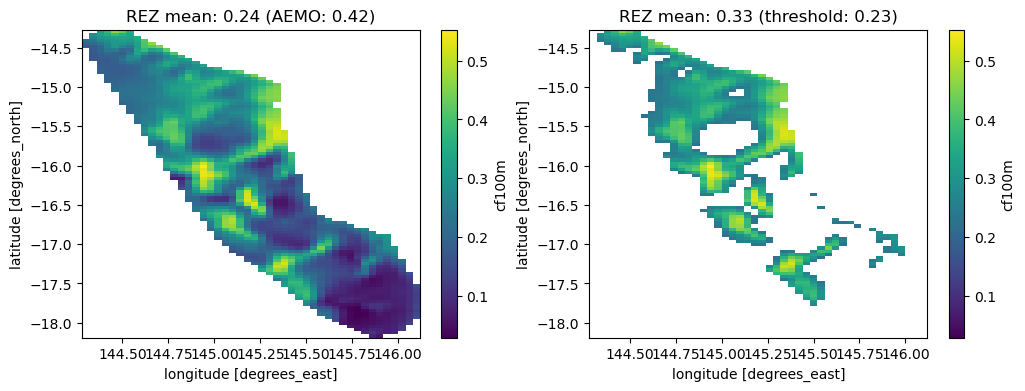

In [148]:
plot_rez_thresh("Q1", q1_mean, q1_thresh, q1_thresh_mean)

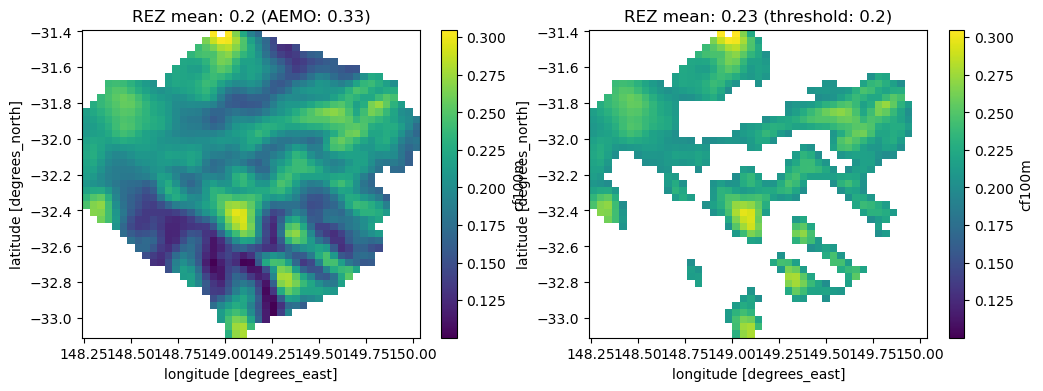

In [149]:
plot_rez_thresh("N3", n3_mean, n3_thresh, n3_thresh_mean)

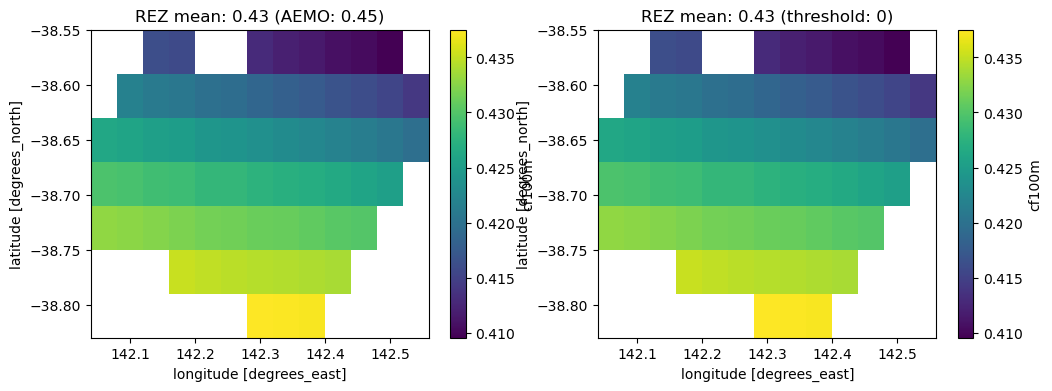

In [150]:
plot_rez_thresh("V8", v8_mean, v8_thresh, v8_thresh_mean)

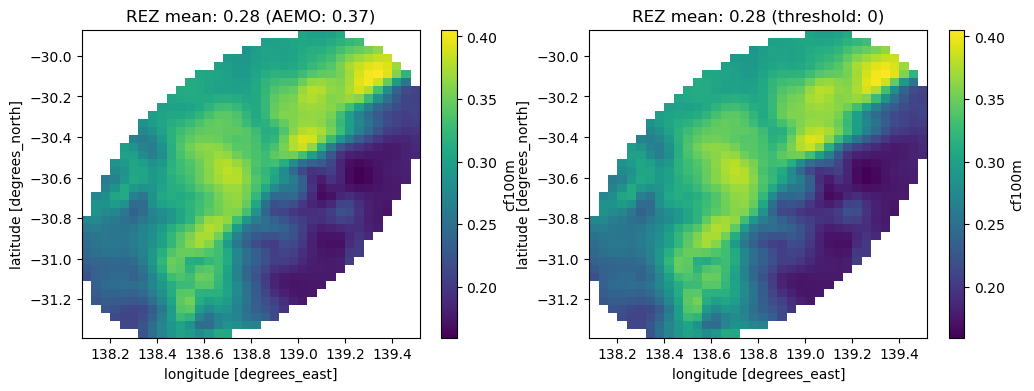

In [151]:
plot_rez_thresh("S6", s6_mean, s6_thresh, s6_thresh_mean)

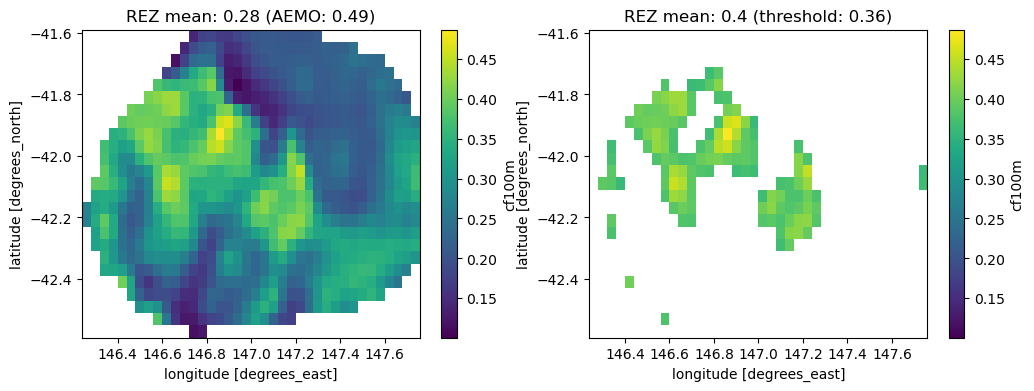

In [152]:
plot_rez_thresh("T3", t3_mean, t3_thresh, t3_thresh_mean)